In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from DataPrep.ImportData import importer
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


In [3]:
m = modelling()
df = m.df.drop(columns=["Charging Time (mins)", "Total Duration (mins)", "Port Number"])

In [4]:
cols_to_standardize = ['# Professional & Other Places', '# Food', '# Shop & Service',
       '# Travel & Transport', '# Outdoors & Recreation',
       '# Arts & Entertainment', '# Nightlife Spot', '# Residence',
       '# College & University', '# Event']

sc = StandardScaler()
stand_poi = sc.fit_transform(df[cols_to_standardize])
stand_poi = pd.DataFrame(stand_poi, index=df.index, columns=cols_to_standardize)
for i in cols_to_standardize:
    df[i] = stand_poi[i]

<IPython.core.display.Javascript object>

In [5]:
df = df.fillna(0)

In [6]:
df.head()

,Start Date,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
0,2011-08-03,0.0,1.679882,-122.16,37.445,0,8,2.098609,1.260311,2.325573,...,0,0,0,1,0,0,0,0,0,0
1,2011-08-04,0.0,1.899242,-122.16,37.445,0,5,1.679882,2.098609,1.260311,...,0,0,0,1,0,0,0,0,0,0
2,2011-08-05,0.0,1.574471,-122.16,37.445,0,10,1.899242,1.679882,2.098609,...,0,0,0,1,0,0,0,0,0,0
3,2011-08-06,0.0,1.982032,-122.16,37.445,0,14,1.574471,1.899242,1.679882,...,0,0,0,1,0,0,0,0,0,1
4,2011-08-07,0.0,2.232860,-122.16,37.445,0,3,1.982032,1.574471,1.899242,...,0,0,0,1,0,0,0,0,0,1


In [7]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")

In [9]:
labels = df.Label.unique()

In [10]:
df_reindex = pd.DataFrame()
idx = pd.period_range(min(df.index), max(df.index))
for i in labels:
    filling = df[df.Label == i].reindex(idx, fill_value = 0)
    filling.Label = i
    df_reindex = df_reindex.append(filling)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df = df_reindex.sort_index()

In [12]:
df.Label.unique()

array([0., 3., 4., 1., 7., 5., 6., 2.])

In [13]:
df.head(30)

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2011-08-03,0.0,1.679882,-122.16,37.445,0,8,2.098609,1.260311,2.325573,1.726841,...,0,0,0,1,0,0,0,0,0,0
2011-08-03,3.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,4.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,1.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,7.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,5.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,6.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,2.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-04,1.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-04,0.0,1.899242,-122.16,37.445,0,5,1.679882,2.098609,1.260311,2.325573,...,0,0,0,1,0,0,0,0,0,0


In [31]:
def create_dataset(X, y, pred_len, time_slot=30*8):
    Xs, ys = [], []
    for i in range(int(len(X)/8 - pred_len)):
        X_start = i*pred_len*8
        X_end = X_start + time_slot
        v = X.iloc[X_start:X_end].values
        Xs.append(v)

        y_start = X_end
        y_end = X_end + pred_len
        ys.append(y[y_start:y_end])
    return np.array(Xs), np.array(ys)

In [58]:
df.shape

(24584, 81)

In [ ]:
y_train[16+182]

In [ ]:
X_train

In [ ]:
df.head()

In [15]:
def ttsplit(df,target="Energy (kWh)",shuffle=False):
    X = df
    y = df[target]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=42,shuffle=shuffle)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.10, random_state=42,shuffle=shuffle)

    return X_train,X_test, X_val,y_train,y_test, y_val

In [112]:
def create_data(X,y, pred_len, time_slot):
    Xs, ys = [], []
    for i in range(int(len(X)/8 - time_slot))):
        X_start = 8 * i
        X_end = X_start + time_slot


        y_start = X_end
        y_end = y_start + pred_len*8

        v = X.iloc[X_start:X_end].values
        Xs.append(v)

        ys.append(y[y_start:y_end])
    return np.array(Xs), np.array(ys)


In [116]:
X = df
y = df["Energy (kWh)"]

In [117]:
X, y = create_data(X,y, 7, 30*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
X.shape

(2833, 240, 81)

In [126]:
2833 - 1983 - 566

284

In [127]:
split = [1983, 284,566]

In [129]:
X_train, X_val, X_test = tf.split(X, split)

<IPython.core.display.Javascript object>

In [130]:
y_train, y_val, y_test = tf.split(y, split)

<IPython.core.display.Javascript object>

In [109]:
X_train, X_test, X_val, y_train, y_test, y_val = ttsplit(df, shuffle = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using 182, cause 182.5 is half a year

In [110]:
X_train,y_train = create_data(X_train, y_train, 1, time_slot = 30*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
X_train[-1].shape

(240, 81)

In [63]:
y_train.shape

(1972, 8)

In [234]:
y_train[]28

array([], dtype=object)

In [111]:
X_test,y_test = create_dataset(X_test, y_test, 1,time_slot = 30*8)

<IPython.core.display.Javascript object>

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


<IPython.core.display.Javascript object>

In [103]:
X_test[-29].shape

(240, 81)

In [99]:
X_val,y_val = create_dataset(X_val, y_val, 1, time_slot = 30*8)

<IPython.core.display.Javascript object>

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


<IPython.core.display.Javascript object>

In [104]:
X_val[-29].shape

(240, 81)

In [154]:
y_test[0]

array([2.43242998, 5.03721921, 2.71452019, 2.2258392 , 2.15274423,
       3.87326304, 2.27759309, 1.97457322, 2.05928571, 2.58753571,
       3.23627273, 1.93005556, 5.01881204, 2.83942857, 1.74857143,
       3.5114    , 1.99416886, 6.46010776, 3.35454315, 3.40268   ,
       2.61699015, 2.32808333, 1.50869482, 2.76279287, 2.226     ,
       3.5179    , 5.03434375, 2.74319048, 2.25441124, 2.8927069 ,
       2.3995814 , 2.86540292, 3.18489963, 2.45117647, 2.72561741,
       3.52323333, 2.59448148, 3.10034568, 2.82238734, 2.7109661 ])

In [155]:
X_test[-40:,1,1:2].flatten()

array([4.96180869, 2.79956272, 2.9529542 , 2.42727146, 2.51215193,
       4.57147619, 2.09304762, 2.3835    , 2.0105625 , 3.04669565,
       2.63319231, 2.77985881, 3.11887097, 1.931     , 1.342     ,
       2.7974    , 3.45477049, 2.3939    , 3.21472727, 4.69566667,
       4.04115609, 2.28756471, 3.37571738, 4.1715625 , 2.5611875 ,
       2.16944776, 2.6304375 , 1.94816667, 3.9095    , 1.95422727,
       2.99046341, 1.94388653, 0.596375  , 3.0597234 , 2.53827027,
       2.49364815, 3.01186275, 2.80158266, 2.52036808, 2.42470833])

In [26]:
X_train[1:2,:,1:2].shape

(1, 1456, 1)

In [783]:
df[1456:1456+8]

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2012-02-01,3.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,5.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,7.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,4.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,6.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,0.0,1.343549,-122.160,37.445,0,3,1.850349,1.157048,1.186390,1.960185,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,1.0,1.335339,-122.163,37.444,0,3,1.305929,1.503150,1.490880,1.424672,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,2.0,1.618067,-122.162,37.447,0,10,2.117777,1.648771,1.364038,1.070227,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_train_new, y_train_new = create_dataset(df[0:2920],df["Energy (kWh)"][0:2920], time_slot = 31*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
X_train_new.shape

(334, 248, 81)

In [28]:
X_val_new, y_val_new = create_dataset(df[2920:2920+1456],df["Energy (kWh)"][2920:2920+1456], time_slot = 31*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
from keras import backend

In [136]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [154]:
inputs = Input(shape=(None,81))
x = LSTM(81, return_sequences = True, activation = "tanh")(inputs)
x = Dropout(0.1)(x)
x = LSTM(75, return_sequences = False, activation = "tanh")(inputs)
x = Dropout(0.5)(x)
x = Dense(60, activation="relu")(x)
outputs = Dense(56)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
#opt = keras.optimizers.Adam(learning_rate=1*10**(-4))
model.compile(optimizer="Adam", loss='mse', metrics=[rmse])

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data = (X_val, y_val))

Epoch 1/100
248/248 [==============================] - 27s 98ms/step - loss: 1.9749 - rmse: 1.3132 - val_loss: 0.7148 - val_rmse: 0.8403
Epoch 2/100
248/248 [==============================] - 24s 95ms/step - loss: 1.1884 - rmse: 1.0644 - val_loss: 0.8459 - val_rmse: 0.9137
Epoch 3/100
248/248 [==============================] - 23s 93ms/step - loss: 1.1637 - rmse: 1.0533 - val_loss: 0.8374 - val_rmse: 0.9091
Epoch 4/100
248/248 [==============================] - 26s 104ms/step - loss: 1.1637 - rmse: 1.0538 - val_loss: 0.7596 - val_rmse: 0.8664
Epoch 5/100
248/248 [==============================] - 26s 103ms/step - loss: 1.1657 - rmse: 1.0545 - val_loss: 0.8073 - val_rmse: 0.8928
Epoch 6/100
248/248 [==============================] - 26s 104ms/step - loss: 1.1521 - rmse: 1.0476 - val_loss: 0.8813 - val_rmse: 0.9330
Epoch 7/100
248/248 [==============================] - 24s 97ms/step - loss: 1.1388 - rmse: 1.0415 - val_loss: 0.8213 - val_rmse: 0.9002
Epoch 8/100
248/248 [=================

In [141]:
X_val.shape

TensorShape([284, 240, 81])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

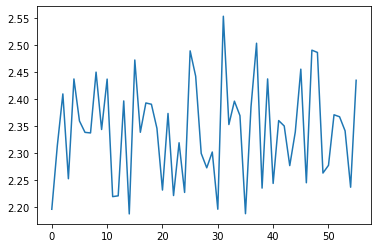

In [161]:

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

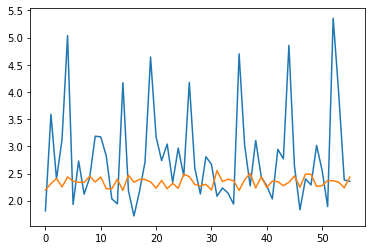

In [163]:
plt.plot(y_val[0])
plt.plot(model.predict(X_val)[0])
plt.show()

In [147]:
X_val[0]

<tf.Tensor: shape=(240, 81), dtype=float64, numpy=
array([[   6.        ,    2.34068723, -122.146     , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    2.78041914, -122.16      , ...,    0.        ,
           0.        ,    0.        ],
       [   5.        ,    3.03460329, -122.158     , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   5.        ,    3.79337143, -122.158     , ...,    0.        ,
           0.        ,    1.        ],
       [   3.        ,    4.81968309, -122.11321931, ...,    0.        ,
           0.        ,    1.        ],
       [   1.        ,    2.44940629, -122.163     , ...,    0.        ,
           0.        ,    1.        ]])>

In [561]:
X_val[0][-1][1]

2.692439024390244

In [580]:
model.predict(np.array(df[-1458:-2]).reshape(1,1456,81))

<IPython.core.display.Javascript object>

array([[2.7247455]], dtype=float32)

In [584]:
X_val.shape

(63, 1456, 81)

In [611]:
float(model.predict(np.array(df[-1458:-2]).reshape(1,1456,81)))

<IPython.core.display.Javascript object>

2.724745512008667

In [612]:
df.iloc[-1]["Energy (kWh)"]

3.383807692307693

In [965]:
def predic():
    preds = []
    for i in range(100):
        pred = float(model.predict(np.array(df[-1358+i:-102+i]).reshape(1,1256,81)))
        preds.append(pred)
    
    return preds

In [967]:
preds = predic()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [968]:
r2_score(np.array(df[-101:-1]["Energy (kWh)"]),np.array(preds))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-4.731077014302545

In [969]:
preds = []
for i in range(X_val.shape[0]):
    pred = model.predict(np.array(X_val[i]).reshape(1,1456,81))
    preds.append(float(pred))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [970]:
preds

[0.5611644983291626,
 0.5701436996459961,
 0.5911750197410583,
 0.5864356756210327,
 0.5948604941368103,
 0.6334630846977234,
 0.5695988535881042,
 0.5648144483566284,
 0.5442633628845215,
 0.4975155293941498,
 0.5873321294784546,
 0.6605113744735718,
 0.5594258308410645,
 0.6802462935447693,
 0.5902557969093323,
 0.6363338828086853,
 0.645184338092804,
 0.6324993371963501,
 0.6544402837753296,
 0.5992485284805298,
 0.5528717041015625,
 0.5810484886169434,
 0.6608498096466064,
 0.6520194411277771,
 0.6644423604011536,
 0.6175932288169861,
 0.6048698425292969,
 0.6740634441375732,
 0.5644179582595825,
 0.636368453502655,
 0.62565678358078,
 0.7037426233291626,
 0.6325733065605164,
 0.6466323137283325,
 0.692121684551239,
 0.5724148750305176,
 0.5354454517364502,
 0.6129343509674072,
 0.6178449988365173,
 0.6450437307357788,
 0.5890757441520691,
 0.5898423194885254,
 0.6192377209663391,
 0.5511139035224915,
 0.6237726211547852,
 0.6506972312927246,
 0.6842180490493774,
 0.696781158447265

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

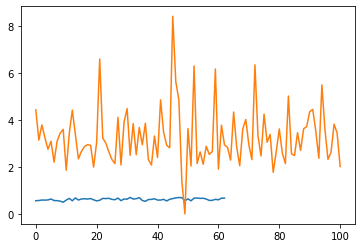

In [971]:
plt.plot(preds)
plt.plot(np.array(df[-102:-1]["Energy (kWh)"]))

## Bayesian Hyperparamter Tuning

In [973]:
import kerastuner as kt

In [974]:
def model_builder(hp):
    model = Sequential()
    mod
    for i in range(hp.Int('LSTM_layers',1,3)):
        model.add(LSTM(hp.Int(f'lstm{i}_units', min_value=10, max_value=80, step=5), return_sequences = True, activation = "tanh"))
        model.add(Dropout(hp.Float(f'lstm{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    for i in range(hp.Int('Dense_layers',1,3)):
        model.add(Dense(hp.Int(f'dense{i}_units', min_value=5, max_value=65, step=5), activation = "relu"))
        model.add(Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    model.add(Dense(1))
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss = 'mse', metrics=['mae'])
    
    return model

In [975]:
def model_builder(hp):

    inputs = Input(shape=(None,81))
    
    x = LSTM(hp.Int('lstm0_units', min_value=20, max_value=60, step=2), return_sequences = True, activation = "tanh")(inputs)
    x = Dropout(hp.Float(f'lstm0_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    lstm_layers = hp.Int('LSTM_layers',1,2)
    for i in range(lstm_layers):
        if i == max(range(lstm_layers)):
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = False, activation = "tanh")(x)
        else:
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = True, activation = "tanh")(x)
        x = Dropout(hp.Float(f'lstm{i + 1}_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    for i in range(hp.Int('Dense_layers',0,3)):
        x = Dense(hp.Int(f'dense_units_{i}', min_value=1, max_value=15, step=1), activation="relu")(x)
        x = Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1))(x)


    outputs = Dense(1)(x)

    m = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
    
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    m.compile(optimizer=opt, loss='mse', metrics=["mae"])

    return m

In [976]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_mae',
                     max_trials = 100,
                     directory='Modelling/HyperParameterTuning',
                     project_name='LSTM_small')

In [977]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

<IPython.core.display.Javascript object>

In [934]:
y_val.shape

(63, 8)

In [978]:
tuner.search(X_train_new, y_train_new, epochs=100 , batch_size=1, validation_data=(X_val_new,y_val_new), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 32 Complete [02h 52m 49s]
val_mae: 0.6668657064437866

Best val_mae So Far: 0.6231744289398193
Total elapsed time: 21h 16m 20s

Search: Running Trial #33

Hyperparameter    |Value             |Best Value So Far 
lstm0_units       |50                |58                
lstm0_dropout     |0.9               |0.9               
LSTM_layers       |1                 |1                 
lstm1_units       |38                |14                
lstm1_dropout     |0.9               |0.9               
Dense_layers      |3                 |2                 
learning_rate     |0.0001            |0.0001            
lstm2_units       |4                 |4                 
lstm2_dropout     |0                 |0.3               
dense_units_0     |1                 |1                 
dense0_dropout    |0                 |0                 
dense_units_1     |1                 |1                 
dense1_dropout    |0.9               |0                 
dense_units_2     |1                 |1  

KeyboardInterrupt: 